In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
!pip install torch torchaudio transformers tqdm
from tqdm import tqdm
import torchaudio
from transformers import Wav2Vec2Processor, HubertForSequenceClassification
# Load the pretrained HuBERT model and processor
from transformers import AutoFeatureExtractor, HubertForSequenceClassification
!pip install torch torchvision torchaudio
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import os
from tqdm import tqdm
import librosa
import torch
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, HubertModel, ViTConfig, ViTForImageClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch.nn as nn
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'

In [5]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)


Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [6]:
# Initialize a dictionary to store file paths for each category
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Iterate over the dataset folders (Bonafide, Spoofed_TTS, Spoofed_Tacotron)
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        # Handle Bonafide folder with Part 1 and Part 2 subfolders
        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    file_path = os.path.join(part_path, file)
                    if file.endswith('.wav'):  # Check if it's a valid audio file
                        audio_files[category].append(file_path)

        # Handle Spoofed_TTS and Spoofed_Tacotron (assuming these don't have parts)
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                file_path = os.path.join(speaker_path, file)
                if file.endswith('.wav'):  # Check if it's a valid audio file
                    audio_files[category].append(file_path)

# Check the loaded audio files
print("Bonafide files:", audio_files['Bonafide'])
print("Spoofed_TTS files:", audio_files['Spoofed_TTS'])
print("Spoofed_Tacotron files:", audio_files['Spoofed_Tacotron'])

Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 258907.65it/s]

Bonafide files: ['/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/10.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/105.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/103.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/101.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/100.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/102.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/316.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/114.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/16.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/458.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/128.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/28.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/313.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/15.wav', '/content/drive/MyDri

In [7]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


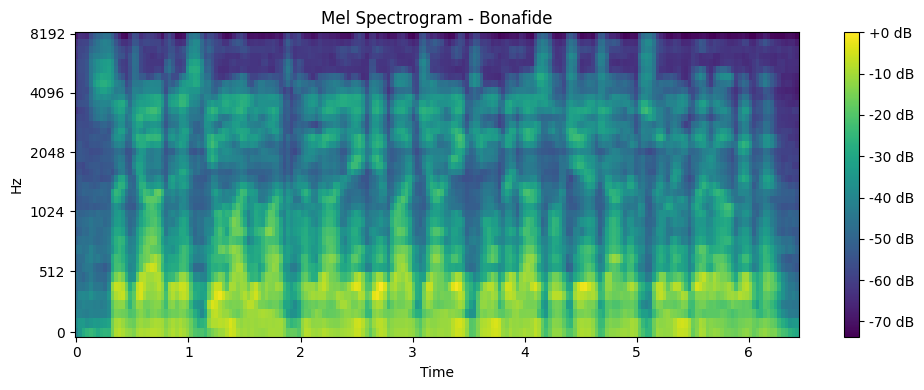

In [8]:
import matplotlib.pyplot as plt
import librosa.display

# Modified function to extract and plot one Mel spectrogram as an example
def extract_and_plot_mel_spectrogram_example(dataset_path, max_length=500):
    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    for file in os.listdir(part_path):
                        file_path = os.path.join(part_path, file)
                        try:
                            # Load and preprocess audio
                            audio, sr = librosa.load(file_path, sr=16000)
                            audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                            # Extract Mel Spectrogram
                            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, fmax=8000)
                            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                            # Plot the spectrogram
                            plt.figure(figsize=(10, 4))
                            librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
                            plt.colorbar(format='%+2.0f dB')
                            plt.title(f"Mel Spectrogram - {category}")
                            plt.tight_layout()
                            plt.show()

                            # Stop after plotting one example
                            return
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
                            continue

# Call the function with your dataset path
extract_and_plot_mel_spectrogram_example('/content/drive/MyDrive/DATASET')

Spectrograms shape: (3418, 224, 224)
Labels shape: (3418,)


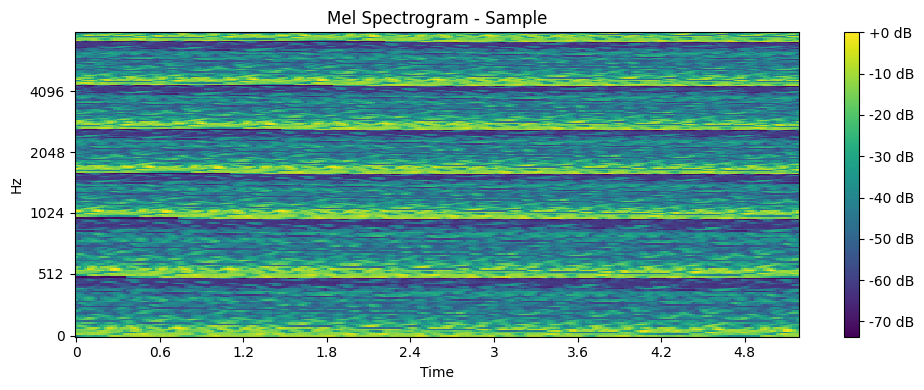

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Function to extract mel spectrograms and store them in arrays
def extract_and_store_mel_spectrograms(dataset_path, max_length=500):
    mel_spectrograms = []
    labels = []  # Labels for the spectrograms (real/fake)

    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    for file in os.listdir(part_path):
                        file_path = os.path.join(part_path, file)
                        try:
                            # Load and preprocess audio
                            audio, sr = librosa.load(file_path, sr=16000)
                            audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                            # Extract Mel Spectrogram
                            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, fmax=8000)
                            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                            # Reshape mel spectrogram to make it compatible for ViT input (224x224x3)
                            mel_spec_db_resized = np.resize(mel_spec_db, (224, 224))  # Resize to 224x224 for ViT input

                            # Append spectrogram and label to the lists
                            mel_spectrograms.append(mel_spec_db_resized)
                            labels.append(0 if category == 'Bonafide' else 1)  # 0 for Bonafide, 1 for Spoofed

                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
                            continue

    # Convert lists to numpy arrays for feeding into ViT
    mel_spectrograms = np.array(mel_spectrograms)
    labels = np.array(labels)

    return mel_spectrograms, labels

# Call the function with your dataset path
mel_spectrograms, labels = extract_and_store_mel_spectrograms('/content/drive/MyDrive/DATASET')

# Check the shape of the spectrograms and labels
print(f"Spectrograms shape: {mel_spectrograms.shape}")
print(f"Labels shape: {labels.shape}")

# You can also visualize a sample spectrogram to verify
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrograms[0], x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram - Sample")
plt.tight_layout()
plt.show()


In [1]:
!pip install tensorflow tensorflow_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
      Successfully uninstalled tensorflow-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incomp

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load pre-trained ViT and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=2  # Binary classification: Real (0) and Fake (1)
)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare dataset
# Expand dimensions to simulate RGB channels (3 channels required for ViT input)
mel_spectrograms_expanded = np.repeat(mel_spectrograms[..., np.newaxis], 3, axis=-1)

# Normalize mel spectrograms
mel_spectrograms_expanded = mel_spectrograms_expanded / np.max(np.abs(mel_spectrograms_expanded), axis=(1, 2, 3), keepdims=True)

# Split dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(
    mel_spectrograms_expanded, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Channels first
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs).logits
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)
evaluate_model(model, test_loader)


Epoch [1/5], Loss: 0.0171
Epoch [2/5], Loss: 0.0024
Epoch [3/5], Loss: 0.0011
Epoch [4/5], Loss: 0.0007
Epoch [5/5], Loss: 0.0004
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


new


Spectrograms shape: (3396, 224, 224)
Labels shape: (3396,)
Total samples extracted: 3396


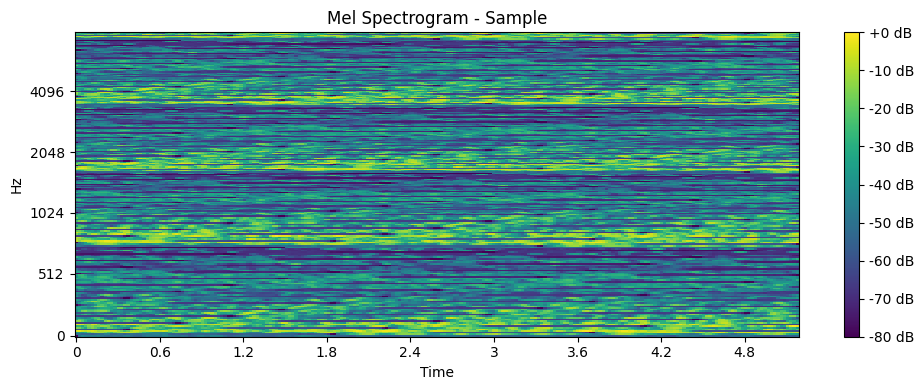

In [9]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Function to extract mel spectrograms and store them in arrays
def extract_and_store_mel_spectrograms(dataset_path, sr=16000, n_mels=40, fmax=8000, target_size=(224, 224)):
    mel_spectrograms = []
    labels = []  # Labels for the spectrograms (real/fake)
    total_samples = 0

    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            # Handle Bonafide Part1 and Part2 structure
            if category == 'Bonafide':
                for part in ['Part1', 'Part2']:
                    part_path = os.path.join(speaker_path, part)
                    if not os.path.exists(part_path):  # Skip if Part1 or Part2 doesn't exist
                        continue

                    for file in os.listdir(part_path):
                        file_path = os.path.join(part_path, file)
                        try:
                            # Load and preprocess audio
                            audio, _ = librosa.load(file_path, sr=sr)
                            audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                            # Extract Mel Spectrogram
                            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=fmax)
                            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                            # Resize mel spectrogram to the target size for ViT
                            mel_spec_db_resized = np.resize(mel_spec_db, target_size)

                            # Append spectrogram and label to the lists
                            mel_spectrograms.append(mel_spec_db_resized)
                            labels.append(0)  # 0 for Bonafide
                            total_samples += 1

                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
                            continue
            else:  # Handle Spoofed_TTS and Spoofed_Tacotron
                for file in os.listdir(speaker_path):
                    file_path = os.path.join(speaker_path, file)
                    try:
                        # Load and preprocess audio
                        audio, _ = librosa.load(file_path, sr=sr)
                        audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                        # Extract Mel Spectrogram
                        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=fmax)
                        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                        # Resize mel spectrogram to the target size for ViT
                        mel_spec_db_resized = np.resize(mel_spec_db, target_size)

                        # Append spectrogram and label to the lists
                        mel_spectrograms.append(mel_spec_db_resized)
                        labels.append(1)  # 1 for Spoofed
                        total_samples += 1

                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                        continue

    # Convert lists to numpy arrays for feeding into ViT
    mel_spectrograms = np.array(mel_spectrograms)
    labels = np.array(labels)

    return mel_spectrograms, labels, total_samples

# Call the function with your dataset path
mel_spectrograms, labels, total_samples = extract_and_store_mel_spectrograms('/content/drive/MyDrive/DATASET')

# Check the shape of the spectrograms and labels
print(f"Spectrograms shape: {mel_spectrograms.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Total samples extracted: {total_samples}")

# Visualize a sample spectrogram to verify
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrograms[0], x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram - Sample")
plt.tight_layout()
plt.show()


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from transformers import ViTForImageClassification
import numpy as np

# Custom Dataset for Mel Spectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spectrogram = self.spectrograms[idx]
        label = self.labels[idx]

        # Convert to 3-channel RGB by duplicating the single channel
        spectrogram = np.stack([spectrogram] * 3, axis=-1)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

# Preprocessing and Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Dataset and DataLoader
dataset = MelSpectrogramDataset(mel_spectrograms, labels, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",  # Use 'google/vit-base-patch16-224' instead
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True  # Ignore size mismatches in the classifier head
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Training Function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# Evaluation Function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)

            # Calculate metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# Train and Evaluate the Model
num_epochs = 7
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Save the Model
torch.save(model.state_dict(), "vit_deepfake_classifier.pth")

Epoch 1/7
Train Loss: 0.0071, Train Accuracy: 0.9996
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 2/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 3/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 4/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 5/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 6/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 7/7
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000


In [13]:
# Example Inference
model.eval()
sample_spectrogram, _ = dataset[0]
sample_spectrogram = sample_spectrogram.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(pixel_values=sample_spectrogram).logits
    prediction = torch.argmax(output, dim=1).item()

print(f"Prediction for the first sample: {'Bonafide' if prediction == 0 else 'Spoofed'}")

Prediction for the first sample: Spoofed
